# Исходные данные

В распоряжении имеются данные о технических характеристиках, комплектации и ценах других автомобилей.

*Признаки*

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя


*Целевой признак*

- Price — цена (евро)

# Задачи

**Главная задача**

Построить модель, которая определит рыночную стоимость автомобиля. Модель будет использована в приложении через которое можно будет узнать рыночную стоимость своего автомобиля. 

Важные критерии:
 - качество предсказания;
 - время обучения модели;
 - время предсказания модели.
 
**Этапы**

1. Выполнить предобработку данных
2. Подготовить выборки для обучения моделей
3. Сравнить характеристики моделей: время обучения, время предсказания, точность результата. Использовать градиентный бустинг и простые модели.
4. Выберать лучшую модель согласно критериям, проверить её качество на тестовой выборке - значение метрики RMSE должно быть меньше 2500.

# Обзор данных

In [1]:
# установка библиотек

%pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# выгрузка библиотек

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [3]:
# открытие файла

try:
    data = pd.read_csv('autos.csv')
except:
     data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')     

In [4]:
# обзор файла

data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
# обзор файла

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
# основные статистики

data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Text(0.5, 1.0, 'Корреляция признаков')

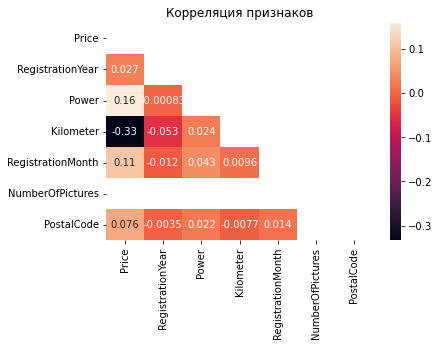

In [7]:
# мультиколлениарность признаков

matrix = np.triu(data.corr())
sns.heatmap(data.corr(), mask=matrix, annot=True)
plt.title('Корреляция признаков')

**Выводы обзора данных**

 - Значение мультиколлениарности не достигает максимума - признаки можно не удалять на этом основании
 
 
 - Удалить колонки DateCrawled (дата скачивания анкеты из базы), DateCreated (дата создания анкеты), NumberOfPictures (количество фотографий автомобиля - частое значение колонки 0), PostalCode (почтовый индекс владельца анкеты) и LastSeen (дата последней активности пользователя)
 
 
 - Провести работу с пропусками данных 
 - Оценить аномалии в значениях (в колонке Price и RegistrationMonth минимальное значение 0, максимальное значение RegistrationYear - 9999)
 
 
 - Преобразовать категориальные признаки, т.к стоит задача регрессии (предсказание цены)

# Предобработка

## Удалим неинформативные колонки для модели

In [8]:
# вначале оценим, данные за какой период представлены

data['DateCrawled']

0         2016-03-24 11:52:17
1         2016-03-24 10:58:45
2         2016-03-14 12:52:21
3         2016-03-17 16:54:04
4         2016-03-31 17:25:20
                 ...         
354364    2016-03-21 09:50:58
354365    2016-03-14 17:48:27
354366    2016-03-05 19:56:21
354367    2016-03-19 18:57:12
354368    2016-03-20 19:41:08
Name: DateCrawled, Length: 354369, dtype: object

In [9]:
# удалим DateCrawled, DateCreated, NumberOfPictures, PostalCode и LastSeen

data = data.drop(columns=['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

## Приведем колонки к единому формату написания

In [10]:
data.columns = data.columns.str.lower()

data = data.rename(columns = {'vehicletype':'vehicle_type',
                              'registrationyear':'registration_year',
                              'registrationmonth':'registration_month',
                              'fueltype':'fuel_type'
                             })

data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

## Проверим наличие полных дубликатов 

In [11]:
data.duplicated().sum()

27543

In [12]:
# удалим дубликаты и проверим данные

data = data.drop_duplicates()
data.duplicated().sum()

0

## Работа с аномальными значениями числовых колонок

In [13]:
# оценим аномальные значения года регистрации

data['registration_year'].value_counts()

2000    22363
1999    20959
2005    20271
2001    18570
2006    18116
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: registration_year, Length: 151, dtype: int64

In [14]:
# т.к аномальные значения практически минимальны - удалим колонки с ними

data = data.loc[(data['registration_year'] > 1900)&(data['registration_year'] < 2016)]

In [15]:
# оценим распределение значений месяца регистрации

data['registration_month'].value_counts()

3     29946
0     28601
6     27259
4     25547
5     25224
7     23774
10    22525
12    20974
11    20739
9     20683
1     20346
8     19498
2     18565
Name: registration_month, dtype: int64

In [16]:
# оценим распределение значений мощности

data['power'].value_counts()

0       30742
75      19967
60      13243
150     12638
101     11311
        ...  
612         1
1596        1
1506        1
5809        1
1241        1
Name: power, Length: 684, dtype: int64

In [17]:
# оценим распределение значений целевого признака

data['price'].value_counts()

0        8089
500      4806
1500     4584
1200     3852
1000     3832
         ... 
615         1
477         1
12560       1
15445       1
14989       1
Name: price, Length: 3677, dtype: int64

Во всех трех колонках, включая целевой признак, присутствуют аномальные значения, равные 0. Причем таких значений достаточно много (до 40 тыс)

In [18]:
# колонка месяца регистрации не так важна - данных c годом регистрации для предсказания модели будет достаточно
# удалим колонку registration_month

data = data.drop(['registration_month'], axis=1)

In [19]:
# т.к колонка price является для нас целевой - аномальные значения придется удалить (они могут повлиять на качество модели)

data = data.loc[data['price'] > 500]

In [20]:
# нулевые значения колонки с мощностью вначале заменим медианой по модели автомобиля

for model in data['model'].unique():
    data.loc[(data['model']==model)&(data['power']==0), 'power'] =\
    data.loc[(data['model']==model), 'power'].median()

In [21]:
# оценим оставшиеся нулевые значения

data[data['power']==0].shape[0]

2574

In [22]:
# оставшиеся нулевые значения в мощности заполним медианой по году регистрации

for year in data['registration_year'].unique():
    data.loc[(data['registration_year']==year)&(data['power']==0), 'power'] =\
    data.loc[(data['registration_year']==year), 'power'].median()

In [23]:
# оценим оставшиеся нулевые значения

data[data['power']==0].shape[0]

9

In [24]:
# удалим строки с оставшимися нулевыми значениями - данные в них будет тяжело восстановить

data = data.loc[data['power']!=0]

## Работа с пропусками

In [25]:
data.isna().sum()

price                    0
vehicle_type          6642
registration_year        0
gearbox               9339
power                    0
model                11147
kilometer                0
fuel_type            14736
brand                    0
repaired             41748
dtype: int64

In [26]:
# количество пропусков в данных доходит почти до 20%
# выделим колонки с пропусками в отдельный список

miss_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

Для заполнения такого большого количества пропусков мог бы быть использован метод KNNImputer. Однако один из критериев проекта - скорость работы. KNNImputer заполнял пропуски 2 фич около 20 минут - поэтому если использовать его для работы с будущими данными, несмотря на возможно более высокое качество заполнения пропусков, скорость подготовки данных к обучению будет достаточно низкой.

Поэтому заменим пропуски на формат 'unknown'

In [27]:
for column in miss_columns:
    data[column] = data[column].fillna('unknown')

In [28]:
# проверим полученные данные

data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

## Преобразование категориальных признаков 

Для дальнейшей работы (заполнения пропусков и работы модели) преобразуем категориальные признаки в числовой формат

Используем технику OrdinalEncoder 

In [29]:
# выделим в список названия колонок категориальных признаков

category = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [30]:
# не забудем о том, что ранее мы удаляли строки и индексация датасета поменялась - сбросим индексацию для дальнейшей работы

data = data.reset_index(drop=True)

In [31]:
# зададим функцию кодирования и сохраним измененные в колонках данные как отдельный датасет

encoder = OrdinalEncoder()
data_category = pd.DataFrame(encoder.fit_transform(data[category]), columns=category)

In [32]:
# удалим из изначального датасета колонки с прямыми категориальными признаками 
# затем добавим откодированные данные, объединив датасеты 

data_new = data.drop(columns=category, axis=1)
data_new = pd.concat([data_new,data_category], axis=1)

In [33]:
# проверим полученный результат

data_new.head()

,price,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,18300,2011,190.0,125000,2.0,1.0,228.0,2.0,1.0,2.0
1,9800,2004,163.0,125000,6.0,0.0,117.0,2.0,14.0,1.0
2,1500,2001,75.0,150000,5.0,1.0,116.0,6.0,38.0,0.0
3,3600,2008,69.0,90000,5.0,1.0,101.0,2.0,31.0,0.0
4,650,1995,102.0,150000,4.0,1.0,11.0,6.0,2.0,2.0


In [34]:
# проверим размерность изначального и полученного датасетов

print('Размерность изначального датасета -', data.shape)
print('Размерность полученного датасета -', data_new.shape)

Размерность изначального датасета - (269414, 10)
Размерность полученного датасета - (269414, 10)


# Подготовка к обучению

In [35]:
# разделим данные на целевой признак и признаки для обучения

X = data_new.drop(['price'], axis=1)
y = data_new['price']

## Стандартизация данных

Стандартиризуем только признаки для обучения - чтоы не изменить масшта целевого признака и ориентироваться на нужный нам показатель RMSE (ниже 2500)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [36]:
# разделим данные на обучающую, валидационную и тестовую выборку 3:1:1

X_common, X_test, y_common, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train, X_valid, y_train, y_valid = train_test_split(X_common, y_common, train_size=0.75, random_state=123)

In [37]:
# проверим размерность полученных выборок

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(161648, 9)
(53883, 9)
(53883, 9)


# Подбор модели

Используем простые модели и оценим их скорость и качество.


## LinearRegression

In [38]:
%%time
# обучение

lr = LinearRegression()
lr.fit(X_train, y_train)

CPU times: total: 15.6 ms
Wall time: 51.4 ms


LinearRegression()

In [39]:
%%time
# предсказание

y_lr_pred = lr.predict(X_valid)

CPU times: total: 0 ns
Wall time: 3.99 ms


In [40]:
# метрика качества

lr_mse = mean_squared_error(y_valid, y_lr_pred)
lr_rmse = lr_mse**.5

print(int(lr_rmse))

3478


**Итог модели Линейной регрессии**

 - Время обучения модели - 93.8 ms, время предсказания - 0 ns
 - Показатель RMSE - 3481

Для следующих моделей подберем лучшие гиперпараметры с помощью GridSearchCV.

##  DecisionTreeRegressor

In [41]:
# зададим параметры поиска по сетке

tree_params = {'max_depth': range (1,11,2),
              'min_samples_leaf': range (1,6),
              'min_samples_split': range (2,8,2) 
              }

In [42]:
# применим GridSearchCV и выведем лучшие параметры

tree = DecisionTreeRegressor()

grid_tree = GridSearchCV(tree, tree_params, cv=5, scoring='neg_mean_squared_error')
grid_tree.fit(X_train, y_train)
grid_tree.best_params_

{'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 6}

In [43]:
%%time
# обучение

best_tree = DecisionTreeRegressor(**grid_tree.best_params_)
best_tree.fit(X_train, y_train)

CPU times: total: 219 ms
Wall time: 225 ms


DecisionTreeRegressor(max_depth=9, min_samples_leaf=4, min_samples_split=6)

In [44]:
%%time
# предсказание

y_tr_pred = best_tree.predict(X_valid)

CPU times: total: 0 ns
Wall time: 8.3 ms


In [45]:
# метрика качества

tr_mse = mean_squared_error(y_valid, y_tr_pred)
tr_rmse = tr_mse**.5

print(int(tr_rmse))

2046


**Итог модели Дерева решений**

 - Лучшие гиперпараметры - max_depth=9, min_samples_leaf=5, min_samples_split=4
 - Время обучения модели - 328 ms, время предсказания - 15.6 ns
 - Показатель RMSE - 2046

## RandomForestRegressor

In [46]:
# зададим параметры поиска по сетке

forest_params = {'n_estimators': range (10, 50, 10),
                 'max_depth': range (1,7,2),
                 'min_samples_leaf': range (1,3),
                 'min_samples_split': range (2,4,2) 
                }

In [47]:
# применим GridSearchCV и выведем лучшие параметры

forest = RandomForestRegressor()

forest_tree = GridSearchCV(forest, forest_params, cv=5, scoring='neg_mean_squared_error')
forest_tree.fit(X_train, y_train)
forest_tree.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

In [48]:
%%time
# обучение

forest_tree = RandomForestRegressor(**forest_tree.best_params_)
forest_tree.fit(X_train, y_train)

CPU times: total: 3.55 s
Wall time: 3.62 s


RandomForestRegressor(max_depth=5, n_estimators=40)

In [49]:
%%time
# предсказание

y_ft_pred = best_tree.predict(X_valid)

CPU times: total: 0 ns
Wall time: 7.04 ms


In [50]:
# метрика качества

ft_mse = mean_squared_error(y_valid, y_ft_pred)
ft_rmse = ft_mse**.5

print(int(ft_rmse))

2046


**Итог модели Случайного леса**

 - Лучшие гиперпараметры - max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=20 
 - Время обучения модели - 2.95 s, время предсказания - 15.6 ns
 - Показатель RMSE - 2046

## Градиентный бустинг 

In [51]:
# создадим датасет для обучения

train_data = lgb.Dataset(X_train, y_train, feature_name=X_common.columns.tolist())

In [52]:
%%time
# обучим модель на основе параметров по умолчанию - ансамбля дереьвев (gbdt) и 100 итераций

booster = lgb.train({'objective':'regression',
                     'metric':'rmse',
                     'boosting':'gbdt'},
                    train_set=train_data, 
                    num_boost_round=100
                   )

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 161648, number of used features: 9
[LightGBM] [Info] Start training from score 5082.137707
CPU times: total: 3 s
Wall time: 350 ms


In [53]:
%%time
# выведем предсказание

y_boost_pred = booster.predict(X_valid)

CPU times: total: 688 ms
Wall time: 58.4 ms


In [54]:
# метрика качества

boost_mse = mean_squared_error(y_valid, y_boost_pred)
boost_rmse = boost_mse**.5

print(int(boost_rmse))

1699


**Итог модели Градиентного бустинга**

 - Гиперпараметры - ансамбль дереьвев (gbdt) и 100 итераций 
 - Время обучения модели - 7.25 s, время предсказания - 1 s
 - Показатель RMSE - 1699 

Попробуем использовать градиентный бустинг непосредственно с Регрессором

In [55]:
%%time
# обучим модель

boost_regressor = lgb.LGBMRegressor(objective='regression', n_estimators=100, verbose=False)
boost_regressor.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric=['rmse'])

LightGBMError: Parameter verbosity should be of type int, got "False"

In [56]:
%%time
# выведем предсказание

y_regr_pred = booster.predict(X_valid)

CPU times: total: 594 ms
Wall time: 61.9 ms


In [57]:
# метрика качества

regr_mse = mean_squared_error(y_valid, y_regr_pred)
regr_rmse = regr_mse**.5

print(int(regr_rmse))

1699


**Итог модели Регрессии градиентного бустинга**

 - Гиперпараметры - 100 итераций 
 - Время обучения модели - 8.58 s, время предсказания - 1.19 s
 - Показатель RMSE - 1699 

## Выбор лучшей модели 

In [58]:
# сгруппируем итоги поиска наилучшей модели

result = {'Время обучения' : ['93.8 ms ', '328 ms ', ' 2.95  s ', '7.25 ', '8.58 s '],
          'Время предсказания': ['0 ns', '15.6 ns', '15.6 ns', '1 s', '1.19 s'],
          'RMSE' : [3481, 2046, 2046, 1699, 1699]
         }

results = pd.DataFrame(data=result, index=['Линейная регрессия', 
                                           'Дерево решений', 
                                           'Случайный лес', 
                                           'Градиентный бустинг через train()', 
                                           'Регрессия градиентного бустинга'])
results['Общее время'] = results['Время обучения'] + results['Время предсказания']

In [59]:
# результаты по RMSE моделей

print('Результаты по RMSE моделей')

display(results.sort_values(by='RMSE'))

Результаты по RMSE моделей


,Время обучения,Время предсказания,RMSE,Общее время
Градиентный бустинг через train(),7.25,1 s,1699,7.25 1 s
Регрессия градиентного бустинга,8.58 s,1.19 s,1699,8.58 s 1.19 s
Дерево решений,328 ms,15.6 ns,2046,328 ms 15.6 ns
Случайный лес,2.95 s,15.6 ns,2046,2.95 s 15.6 ns
Линейная регрессия,93.8 ms,0 ns,3481,93.8 ms 0 ns


**Вывод**

 - Самый низкий показатель RMSE (ошибка в 1699 евро) и самое высокое качество у моделей градиентного бустинга, однако у них самое высокое время работы - время обучения 7.25 s и время предсказания 1 s для градиентного бустинга через train(); и время обучения 8.58 s и время предсказания 1.19 s для регрессии градиентного бустинга.
 
Несмотря на высокое качество модели применять ее нецелевообразно из-за долгого времени работы.
 
 - Немного выше показатель RMSE имеет модель Дерева решений (2046), при этом ее время достаточно быстрое - 328 ms обучения и 15.6 ns предсказания.
 
 Эту модель мы будем в дальнейшем использовать и проведем на ней тестирование.

# Тест

Выведем алгоритм модели, с которой будем работать.

In [60]:
def predict_price(X_train, y_train, X_test, y_test):
    
    model = DecisionTreeRegressor(max_depth=9, min_samples_leaf=5, min_samples_split=4, random_state=123)
    
    # обучаем модель
    model.fit(X_train, y_train)
    
    # выводим предсказание
    y_pred = model.predict(X_test)
    
    # метрика качества
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse**.5
    
    return int(rmse)

In [61]:
%%time
# воспользуемся функцией

test_rmse = predict_price(X_common, y_common, X_test, y_test)

print('RMSE тестовой выборки', test_rmse)

RMSE тестовой выборки 2040
CPU times: total: 391 ms
Wall time: 303 ms


# Итог работы

1. Была проведена предобработка данных:

  - проверка мультиколлениарности признаков 
  - удаление неинформативных для модели колонок
  - проверка на полные дубликаты
  - работа с аномальными признаками
  - работа с пропусками в данных
  - кодирование категориальных признаков OrdinalEncoder
  - стандартизация признаков обучения
  
  
2. Проведен анализ следующих моделей:

  - Линейная регрессия
  - Вывод оптимального Дерева решений поиском по сетке GridSearchCV
  - Вывод оптимального Случайного леса поиском по сетке GridSearchCV
  - Градиентный бустинг на основе деревьев методом train
  - Градиентный бустинг с помощью LGBMRegressor-а
  
По итогу анализа моделей можно сделать следующие выводы:

 - Самое лучшее качество (RMSE 1718) показали модели градиентного бустинга, однако их время работы самое долгое (7-8 секунд обучение и 1 секунда и выше предсказание)
 - Второе место по качеству (RMSE 2093) занимают модели Дерева решений и Случайного леса, при этом время работы Дерева решений ожидаемо более низкое (328 ms обучение и 15.6 ns предсказание) по сравнению с Случайным лесом (2.95 s обучение и 15.6 ns предсказание)
 - Модель Линейной регрессии работает крайне быстро (93.8 ms обучение и 0 ns предсказание), однако ее качество крайне низкое (RMSE 3481) - и превышает желаемый показатель метрики 
 
3. На основе анализа моделей итоговой выбрана модель Дерева решений с подобранными ранее гиперпараметрами. Построена функция для работы модели.

Итоговое время обучения модели и предсказания составило 391 ms. RMSE тестовой выборки - 2040. 